# Using Natural Language Processing to Classify Patents Technologies

## Business Understanding
Patents provide a wealth of data since their data has been compiled by a variety of parties in a variety of ways, both public and private. To name a few, public patent data can be accessed via websites for the U.S. Patent & Trademark Office (USPTO), foreign patent offices, Google Patents, etc. Data for this project has been obtained from [PatentsView.org](PatentsView.org), which is a visualization, data dissemination, and analysis platform provided by the USPTO.

Various types of information on patents are connected at various stages in a patent's life, one being the classification of a patent's technology (e.g. mechanical, chemistry, electrical, etc.) This classification is assigned some time after a patent is filed, but it could be useful to try and predict how a patent will be classified before it is filed. In this project, I will be attempting to use machine learning to predict classifications. There are many types of classification systems ranging from broad to very specific, so for the purposes of this project, I will focus on a broader classification system.

## Data Understanding
To provide some background on how a patent is structured, there are 4 main parts. They are:
1) Coverpage, which provides bibliographic information such as who the inventors are, what the title is, a summary, what patents are related, etc.; 
2) Specification, which provides background information on the given invention;
3) Drawings, which serve to illustrate the invention; and
4) Claims, which detail the specific aspects of an invention that the applicant wants legally protected. 

Here is a link to patent [#10 million](https://patentimages.storage.googleapis.com/c0/d5/f7/86ad5b42759506/US10000000.pdf) if you are curious what the actual document looks like.

I mention these because in this project, we will use the first claim of U.S. patents to predict the classification. Claims are much shorter and more specific than the entire specification (a few lines vs. many page) and follow a similar grammatical structure. This structure is a product of patent attorneys seeking to obtain specific and predictable legal protections, and may help in pattern recognition. Alternatively, the styles of the specifications are highly personalized to the author of the patent since the rules for the contents are not as rigid. Lastly, since each patent is required to contain at least one claim, we are guaranteed that there will not be missing data for any given patent we are analyzing. 

## Data Preparation
Currently, there have been over 10 million patents granted in the U.S., so the first thing to do is reduce the amount of data being used for modeling since I am limited to what Google Collab can run in a couple hours. The parameters I used to select the data for training are:
1) Patents from the last 10 years. This provides more than 3 million patents for further trimming.
2) Using the World Intellectual Property Organization's (WIPO) classifications, found [here](https://patentsview.org/download/data-download-tables), which are the broadest having only 5 classifications:
    - Electrical engineering
    - Mechanical engineering
    - Instruments
    - Chemistry 
    - Other (which patents I eliminated since I wanted to focus on data with an actual label)
3) Getting rid of data having more than one classification
The first claim is typically considered the most important. A smaller amount of data should reduce the computing power required.
4) Keeping only the first claim for each patent, which is usually the most important claim of a patent.

In [22]:
#import packages
import pandas as pd
import numpy as np
import string
import re
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
import pickle

from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from matplotlib.pyplot import savefig, title
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

# import my custom library into colab
import sys
sys.path.append('/content/gdrive/MyDrive/Github/capstone/')
import mylibrary as mylib

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
%cd /content/gdrive/My Drive/Github/capstone

/content/gdrive/My Drive/Github/capstone


## Modeling & Evaluation
I wanted to look at how a few different sets of models and also compare how they would perform in dual or multiclass situations. 

###Models with 2-classes

In [25]:
# Load train and test data
X_train = pd.read_pickle('data/X_train_2class.pkl')
X_test = pd.read_pickle('data/X_test_2class.pkl')
y_train = pd.read_pickle('data/y_train_2class.pkl')
y_test = pd.read_pickle('data/y_test_2class.pkl')

In [26]:
# Load previously trained models
logreg = pickle.load(open('data/model_logreg.pkl', 'rb'))
model_dt = pickle.load(open('data/model_dt.pkl', 'rb'))
model_xgb = pickle.load(open('data/model_xgb.pkl', 'rb'))
model_gs_xgb = pickle.load(open('data/model_gs_xgb_2class.pkl', 'rb'))

####Model 1 - Logistic Regression

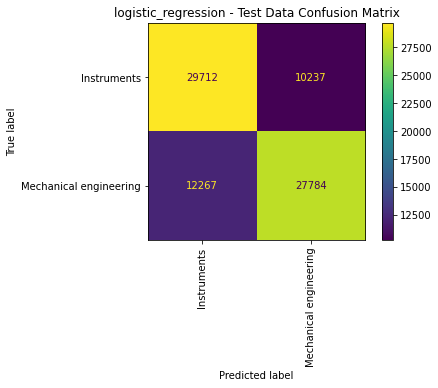

In [27]:
# Generate confusion matrix and save scores
logreg_scores = mylib.model_scores_only(logreg, 'logistic_regression', 
                                        X_train, X_test, 
                                        y_train, y_test)

####Model 2 - Decision Tree

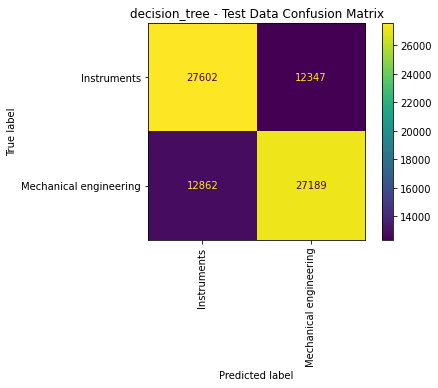

In [28]:
# Generate confusion matrix and save scores
dt_scores = mylib.model_scores_only(model_dt, 'decision_tree',
                                        X_train, X_test, 
                                        y_train, y_test)

####Model 3 - XG Boost

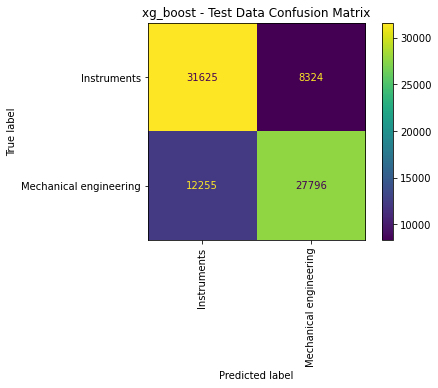

In [29]:
# Generate confusion matrix and save scores
xgb_scores = mylib.model_scores_only(model_xgb, 'xg_boost',
                                   X_train, X_test, 
                                   y_train, y_test)

In [30]:
# Compare the accuracy scores from the 3 previous models
scores = pd.concat([logreg_scores, dt_scores, xgb_scores])
scores

,train_accuracy,test_accuracy,train_recall,test_recall,train_f1,test_f1
logistic_regression,0.716778,0.718700,0.743276,0.743748,0.724153,0.725320
decision_tree,0.993556,0.684887,0.998269,0.690931,0.993589,0.686506
xg_boost,0.742072,0.742762,0.791204,0.791634,0.754210,0.754512


Comparing the scores, the XG Boost model is the most promising, so running a gridsearch to optimize parameters, we get the following.

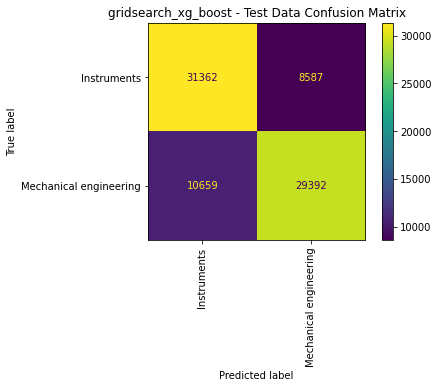

In [31]:
xgb_gs_scores = mylib.model_scores_only(model_gs_xgb, 'gridsearch_xg_boost',
                                   X_train, X_test, 
                                   y_train, y_test)

In [32]:
xgb_gs_scores

,train_accuracy,test_accuracy,train_recall,test_recall,train_f1,test_f1
gridsearch_xg_boost,0.782078,0.759425,0.809736,0.785051,0.787996,0.765207


We now want to look at the words that were most important in determining the classification.

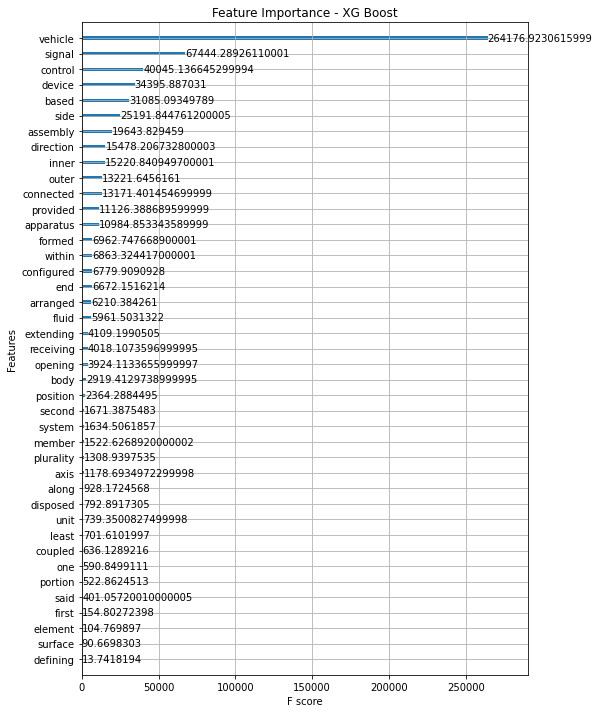

<Figure size 432x288 with 0 Axes>

In [33]:
# plot feature importance
ax = plot_importance(model_xgb, importance_type='total_gain')
plt.title('Feature Importance - XG Boost')
fig = ax.figure
fig.set_size_inches(8, 12)
plt.show()
savefig(f'images/feature_importance_xgb.png', bbox_inches='tight', dpi=300)

The algorithm seems to have picked up on technical keywords like "vehicle" and "signal", but also interestingly seems to have picked up on stylistic words like "provided" and "within". 

Now, let's look at what the major influences on the multiclass model look like.

##Model with Multiclass

In [34]:
# Load train and test pickles
X_train = pd.read_pickle('data/X_train_4class.pkl')
X_test = pd.read_pickle('data/X_test_4class.pkl')
y_train = pd.read_pickle('data/y_train_4class.pkl')
y_test = pd.read_pickle('data/y_test_4class.pkl')

In [35]:
# Load previously trained models.
model_lr = pickle.load(open('data/model_logreg_4class.pkl', 'rb'))
model_dt = pickle.load(open('data/model_dt_4class.pkl', 'rb'))
model_xgb = pickle.load(open('data/model_xgb_4class.pkl', 'rb'))
model_gs_xgb = pickle.load(open('data/model_xgb_gs_4class.pkl', 'rb'))

####Model 1 - Logistic Regression

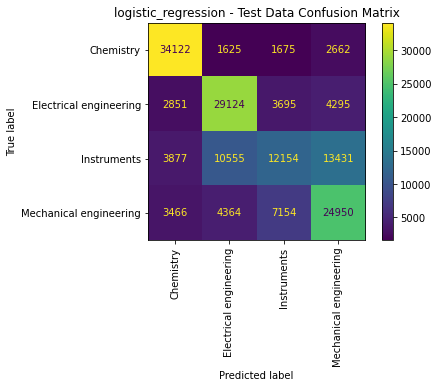

In [36]:
# Evaluate model
logreg_scores2 = mylib.model_scores_only(model_lr, 'logistic_regression',
                                        X_train, X_test, 
                                        y_train, y_test)

####Model 2 - Decision Tree

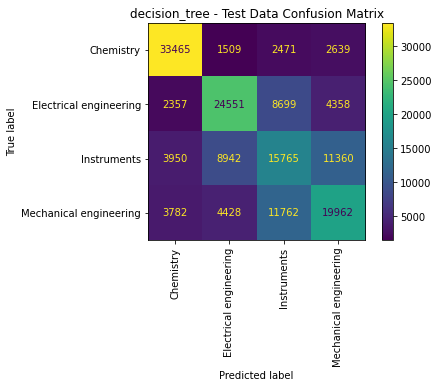

In [37]:
# Evaluate next model
dt_scores2 = mylib.model_scores_only(model_dt, 'decision_tree',
                                        X_train, X_test, 
                                        y_train, y_test)

####Model 3 - XG Boost

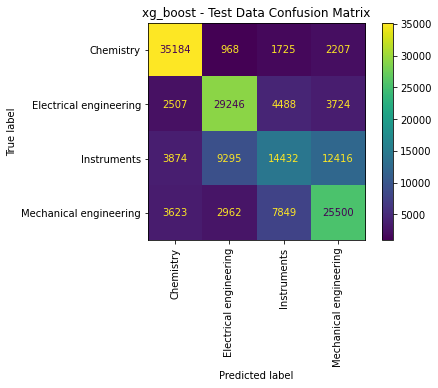

In [38]:
xgb_scores2 = mylib.model_scores_only(model_xgb, 'xg_boost',
                                   X_train, X_test, 
                                   y_train, y_test)

In [39]:
scores = pd.concat([logreg_scores2, dt_scores2, xgb_scores2])
scores

,train_accuracy,test_accuracy
logistic_regression,0.626788,0.627188
decision_tree,0.961248,0.585894
xg_boost,0.652264,0.652262


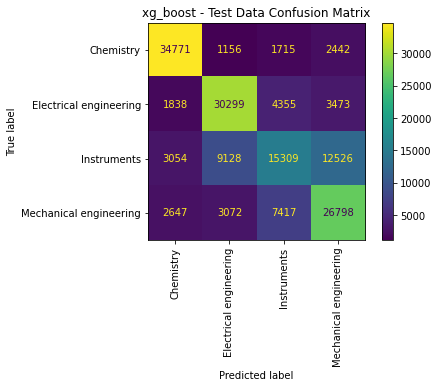

In [40]:
xgb_gs_scores2 = mylib.model_scores_only(model_gs_xgb, 'xg_boost',
                                        X_train, X_test, 
                                        y_train, y_test)

In [43]:
xgb_gs_scores2

,train_accuracy,test_accuracy
xg_boost,0.685386,0.669856


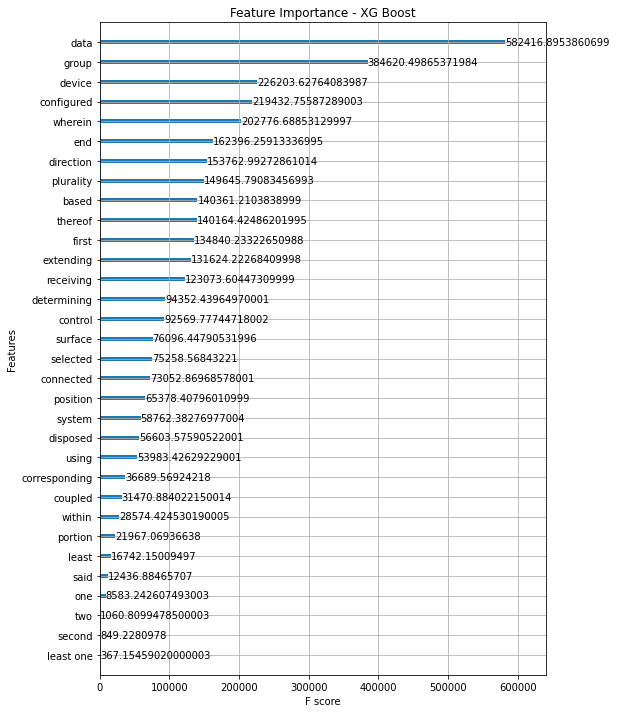

<Figure size 432x288 with 0 Axes>

In [42]:
# plot feature importance
ax = plot_importance(model_xgb, importance_type='total_gain')
plt.title('Feature Importance - XG Boost')
fig = ax.figure
fig.set_size_inches(8, 12)
plt.show()
savefig(f'images/feature_importance_xgb_4class.png', bbox_inches='tight', dpi=300)